In [152]:
import magic
import pandas as pd 
import seaborn as sns
import scanpy as sc
import numpy as np
import scanpy.external as sce
from numpy.random import seed
from numpy.random import normal
from random import sample
from random import choices

In [153]:
from scipy.stats import rv_discrete, rv_continuous
from scipy.stats import nbinom


# distribution plotting utilities
def is_discrete(dist):

    if hasattr(dist, 'dist'):
        return isinstance(dist.dist, rv_discrete)
    else: return isinstance(dist, rv_discrete)

def is_continuous(dist):

    if hasattr(dist, 'dist'):
        return isinstance(dist.dist, rv_continuous)
    else: return isinstance(dist, rv_continuous)

def plot_distrib(distrib, title=None):

    fig, ax = plt.subplots(1, 1)

    if is_continuous(distrib):
        x = np.linspace(distrib.ppf(0.001),
                        distrib.ppf(0.999), 1000)
        ax.plot(x, distrib.pdf(x), 'k-', lw=0.4)

    elif is_discrete(distrib):
        x = np.arange(distrib.ppf(0.01),
                      distrib.ppf(0.99))
        ax.plot(x, distrib.pmf(x), 'bo', ms=2, lw=0.4)

    r = distrib.rvs(size=1000)
    ax.hist(r, density=True, histtype='stepfilled', alpha=0.2, bins=200)

    if title: ax.set_title(title)
    fig_style_2(ax)
    return ax

def fig_style_2(ax):
    for side in ["right","top","left"]: ax.spines[side].set_visible(False)
    ax.get_yaxis().set_visible(False)




Rna_species_characteristic_numbers = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000]

n = 100
p = 0.5

cell_generator = [nbinom(n, p) for n in Rna_species_characteristic_numbers]
    
def sample_cells(cell_generator, num=100): 
    df = pd.DataFrame([dist.rvs(num) for dist in cell_generator]).T
    df = df.set_axis([f"Gene {g + 1}" for g in range(len(df.columns))], axis=1, inplace=False)
    return df


synth_cells = sample_cells(cell_generator)

sim_capture = lambda x, p: sum(choices([0, 1], weights=[1-p, p])[0] for _ in range(x))

def simulate_capture_all_cells(true_cells, capture_rate):
    return df.applymap(lambda x: sim_capture(x, p=capture_rate))

    
for i, row in df.iterrows():
    
    # row is a pd.Series
    np.random.choice(row.values, replace=False)

In [154]:
merfish_repr = simulate_capture_all_cells(synth_cells, 0.9)
tenx_repr = simulate_capture_all_cells(synth_cells, 0.3)

In [155]:
def generate_synthetic_cells(mean=100, std=10, num_cells=1_000, num_genes=10, gene_coefficients = [1]):
    '''
    Generating a synthetic cell with genes expressed as a normal distribution w/ varying means
    
    mean = mean of norm distr
    std = standard devation of norm distr
    num_cells = number of cells 
    num_genes = number of genes per cell
    gene_coefficients = pool of gene_coefficients to resemble varying expression
    '''
    assert isinstance(gene_coefficients, list), "gene_coefficients should be passed in as list"
    
    gene_coeff = sample(gene_coeff,num_genes) # randomly samplying coefficients
    data = {f"Gene {g + 1}": normal(loc=gene_coeff[g]*mean, scale=std, size=size) 
            for g in range(num_genes)}
    data = pd.DataFrame(data)
    data = data.abs() # remove any negative expression
    return data

In [156]:
def gen_synthetic_data(dataset, mean=100, std=10, size=1_000, num_genes=10):
    data = {f"Gene {g + 1}": normal(loc=gene_coeff[g]*mean, scale=std, size=size) 
            for g in range(num_genes)}
    data = pd.DataFrame(data)
    data = data.abs()
    return data

def ready_for_plot():
    merfish_repr["Model"] = "MERFISH"
    tenx_repr["Model"] = "10X synthetic"
    return pd.concat([merfish_repr, tenx_repr])

def rescale_data(data, target_data, rescale):
    if rescale == 0:
        return data
    else:
        data[data < 0] = 0
        M99 = np.percentile(target_data, rescale, axis=0)
        M100 = target_data.max(axis=0)
        indices = np.where(M99 == 0)[0]
        M99[indices] = M100[indices]
        M99_new = np.percentile(data, rescale, axis=0)
        M100_new = data.max(axis=0)
        indices = np.where(M99_new == 0)[0]
        M99_new[indices] = M100_new[indices]
        max_ratio = np.divide(M99, M99_new)
        data = np.multiply(data, np.tile(max_ratio,
                                      (target_data.shape[0], 1)))
        print(max_ratio)
    return data

In [127]:
pool = [1/4, 1/2, 2/3, 1, 4/3, 2, 4, 10, 20]
MEAN = 100
STD = 10
SIZE = 1_000
GENES = 10

In [157]:
# gene_coeff = [sample(pool,1)[0] for g in range(GENES)]
# # pooling factors for genes

# merfish_repr = gen_synthetic_data(0.9*MEAN, STD, SIZE, "MERFISH", GENES)
# tenx_repr = gen_synthetic_data(0.3*MEAN, STD, SIZE, "10X synthetic", GENES)

joint_data = ready_for_plot()

/var/folders/w5/qsmlzn8n4b9dzq_r63twss1h0000gn/T/ipykernel_99091/705731123.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  merfish_rna_counts = merfish_repr.sum(axis=1)


Text(0.5, 1.0, 'MERFISH RNA count for each cell. Median = 13001.0')

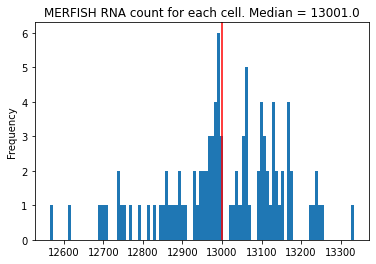

In [158]:
merfish_rna_counts = merfish_repr.sum(axis=1)
ax = merfish_rna_counts.plot.hist(bins=100)
ax.axvline(merfish_rna_counts.median(), c='r')
ax.set_title(f'MERFISH RNA count for each cell. Median = {merfish_rna_counts.median()}')

In [159]:
normalized_sum = int(merfish_rna_counts.median())

<AxesSubplot:xlabel='Gene 1', ylabel='Gene 8'>

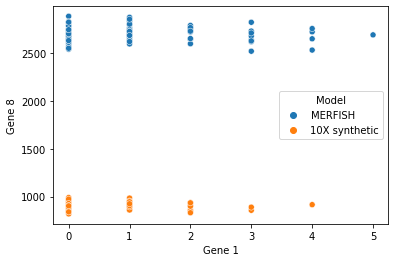

In [200]:
sns.scatterplot(data=joint_data, x="Gene 1", y ="Gene 8", hue="Model")

## Normalize counts

In [161]:
merfish_repr = merfish_repr.drop(columns=["Model"])
tenx_repr = tenx_repr.drop(columns=["Model"])

merfish_repr = sc.AnnData(merfish_repr)
tenx_repr = sc.AnnData(tenx_repr)

sc.pp.normalize_total(merfish_repr, target_sum=normalized_sum)
tenx_norm = tenx_repr.copy()
sc.pp.normalize_total(tenx_norm, target_sum=normalized_sum)

sc.pp.normalize_total(tenx_repr)
tenx_raw = tenx_repr.to_df() # use later for rescaling
sc.pp.sqrt(tenx_repr)

/var/folders/w5/qsmlzn8n4b9dzq_r63twss1h0000gn/T/ipykernel_99091/3313670847.py:4: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  merfish_repr = sc.AnnData(merfish_repr)
/Users/saulvegasauceda/opt/anaconda3/envs/magic-env/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/var/folders/w5/qsmlzn8n4b9dzq_r63twss1h0000gn/T/ipykernel_99091/3313670847.py:5: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tenx_repr = sc.AnnData(tenx_repr)


### Before running MAGIC

In [162]:
sce.pp.magic(tenx_repr, name_list='all_genes', solver='exact', n_jobs=-1)

/Users/saulvegasauceda/.local/lib/python3.10/site-packages/magic/utils.py:145: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  data = anndata.AnnData(data)


### After running MAGIC

In [163]:
tenx_repr.X = tenx_repr.X**2

### After squaring vals

In [182]:
tenx_rescaled_norm = tenx_repr.copy()
imputed_rescaled_df = tenx_rescaled_norm.to_df()

In [183]:
imputed_rescaled_df = rescale_data(imputed_rescaled_df, tenx_raw, 99)

[7.25548531 2.98673327 2.12028012 1.97997558 1.38302608 1.18474775
 1.09130563 1.05188544 1.0186619 ]


In [184]:
imputed_rescaled_df

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9
0,0.171116,0.771899,4.442130,17.552976,39.709695,111.047387,325.525997,934.701136,3076.085879
1,0.392987,0.447322,4.693307,17.839943,40.284328,107.343505,327.363512,946.066173,3065.937310
2,2.247011,0.470682,4.526604,19.727532,42.680727,109.183763,334.696421,944.693983,3055.915080
3,3.061544,1.989113,5.637200,16.624898,41.040955,102.236413,331.763271,944.698092,3066.260367
4,0.285596,2.265594,6.041399,15.812548,40.320203,107.234785,332.547780,954.186954,3053.091377
...,...,...,...,...,...,...,...,...,...
95,0.144593,0.320036,7.716117,15.288243,36.830627,102.497999,332.275287,951.825091,3062.424469
96,0.411992,2.025787,5.927769,16.907621,39.143932,103.355575,336.646771,950.443657,3056.646994
97,0.190416,2.104488,5.332029,16.266416,41.189493,109.481686,327.523105,943.898585,3065.348396
98,0.130051,0.242302,5.564287,16.806950,35.791358,109.574551,328.565754,948.338345,3064.225033


In [185]:
imputed_rescaled = sc.AnnData(imputed_rescaled_df)

/var/folders/w5/qsmlzn8n4b9dzq_r63twss1h0000gn/T/ipykernel_99091/3371897545.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  imputed_rescaled = sc.AnnData(imputed_rescaled_df)


In [192]:
sc.pp.normalize_total(tenx_repr, target_sum=normalized_sum)
sc.pp.normalize_total(imputed_rescaled, target_sum=normalized_sum)

In [193]:
imputed_df = tenx_repr.to_df()
imputed_rescaled_df = imputed_rescaled.to_df()
merfish_df = merfish_repr.to_df()
tenx_norm_df = tenx_norm.to_df()

In [213]:
imputed_df["Model"] = "10x Imputed Norm"
imputed_rescaled_df["Model"] = "10x Imputed Rescaled"
tenx_norm_df["Model"] = "10x norm"
merfish_df["Model"] = "MERFISH norm"
synth_cells["Model"] = "True cells"

In [218]:
after_imputation = pd.concat([imputed_rescaled_df,merfish_df, tenx_norm_df, synth_cells], ignore_index=True)
before_imputation = pd.concat([merfish_df, tenx_norm_df, synth_cells], ignore_index=True)

<AxesSubplot:xlabel='Gene 7', ylabel='Gene 8'>

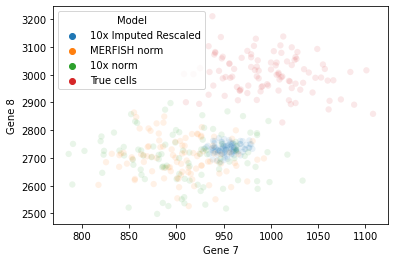

In [219]:
sns.scatterplot(data=after_imputation, x="Gene 7", y ="Gene 8", hue="Model", alpha=0.1, s=40)

<AxesSubplot:xlabel='Gene 7', ylabel='Gene 8'>

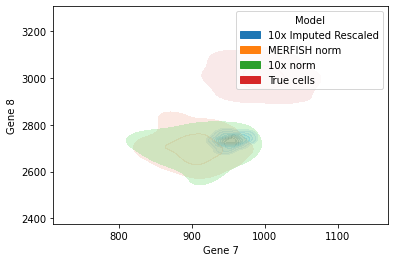

In [221]:
sns.kdeplot(data=after_imputation, x="Gene 7", y ="Gene 8", hue="Model", alpha=0.3, fill=True)

## MERFISH vs. 10x (pre-imputation)

## Raw counts

<AxesSubplot:xlabel='Gene 5', ylabel='Gene 6'>

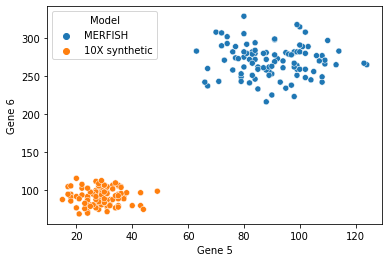

In [198]:
sns.scatterplot(data=joint_data, x="Gene 5", y ="Gene 6", hue="Model")

<AxesSubplot:xlabel='Gene 7', ylabel='Gene 8'>

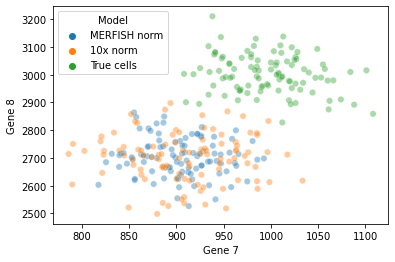

In [223]:
sns.scatterplot(data=before_imputation, x="Gene 7", y ="Gene 8", hue="Model", alpha=0.4, s=40)